# Part 1 - NetworkX

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('ner_predictions.csv')

In [2]:
df['entities'] = df['entities'].apply(lambda x: eval(x))


In [3]:
df.iloc[1, -1]

[{'entity_group': 'PER',
  'score': np.float32(0.9964051),
  'word': 'Mad',
  'start': 4,
  'end': 7},
 {'entity_group': 'ORG',
  'score': np.float32(0.997514),
  'word': 'Kent State University',
  'start': 189,
  'end': 210},
 {'entity_group': 'ORG',
  'score': np.float32(0.9855803),
  'word': 'IE',
  'start': 323,
  'end': 325},
 {'entity_group': 'LOC',
  'score': np.float32(0.999089),
  'word': 'US',
  'start': 502,
  'end': 504},
 {'entity_group': 'MISC',
  'score': np.float32(0.9108819),
  'word': 'Fortune 100',
  'start': 628,
  'end': 639},
 {'entity_group': 'ORG',
  'score': np.float32(0.99896765),
  'word': 'GE',
  'start': 658,
  'end': 660},
 {'entity_group': 'ORG',
  'score': np.float32(0.99409735),
  'word': 'Halliburton',
  'start': 665,
  'end': 676},
 {'entity_group': 'ORG',
  'score': np.float32(0.9987676),
  'word': 'Millwood Inc',
  'start': 700,
  'end': 712},
 {'entity_group': 'ORG',
  'score': np.float32(0.6950334),
  'word': 'Strategic Business Unit',
  'start': 

In [4]:
import networkx as nx
G = nx.Graph()

In [6]:

for _, row in df.iterrows():
    prof = row['alias']
    G.add_node(prof, type='PROF')

    for entity in row['entities']:
        G.add_node(entity['word'], type=entity['entity_group'])
        G.add_edge(prof, entity['word'], realation=entity['entity_group'])


In [11]:
color_map = []
for node, data in G.nodes(data=True):
    if data["type"] == "PROF":
        color_map.append("lightblue")
    elif data["type"] == "ORG":
        color_map.append("lightgreen")
    elif data["type"] == "LOC":
        color_map.append("salmon")
    else:
        color_map.append("gray")

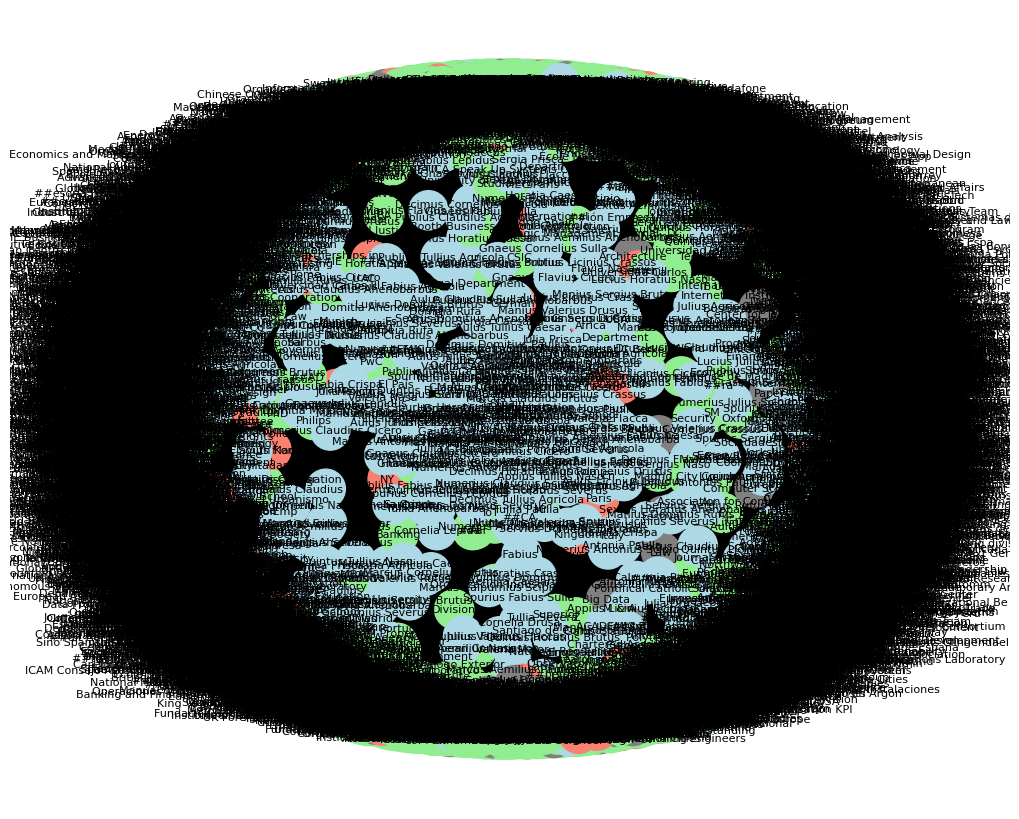

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.6, seed=42)
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=800, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, "relation"), font_size=7)
plt.show()